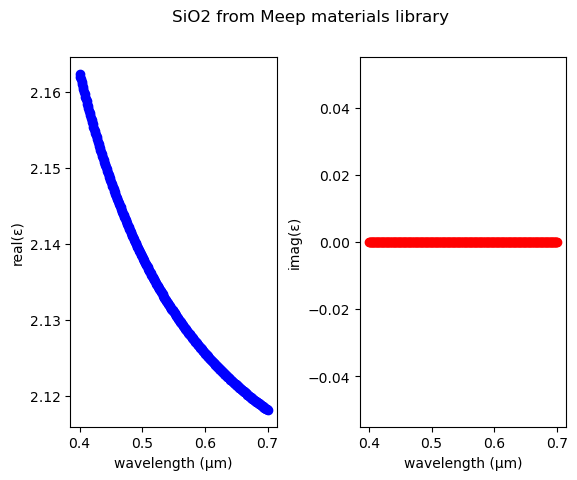

In [32]:
import meep as mp
import meep.adjoint as mpa
# from meep.materials import SiO2
import numpy as np
import matplotlib.pyplot as plt

um_scale = 1
resolution = 50

SiO2_frq1 = 10.127666905810576 / um_scale
SiO2_gam1 = 0.0
SiO2_sig1 = 0.3552070928843716
SiO2_frq2 = 10.17959774885804 / um_scale
SiO2_gam2 = 0.0
SiO2_sig2 = 0.642824819858993


SiO2_susc = [
    mp.LorentzianSusceptibility(frequency=SiO2_frq1, gamma=SiO2_gam1, sigma=SiO2_sig1),
    mp.LorentzianSusceptibility(frequency=SiO2_frq2, gamma=SiO2_gam2, sigma=SiO2_sig2),
]
SiO2 = mp.Medium(
    epsilon=1.1, E_susceptibilities=SiO2_susc)


wvl_min = 0.4 * um_scale# units of μm
wvl_max = 0.7 * um_scale # units of μm
nwvls = 300
wvls = np.linspace(wvl_min, wvl_max, nwvls)

SiO2_epsilon = np.array([SiO2.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(SiO2_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(SiO2_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('SiO2 from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.savefig("epsilon")

In [6]:
pml_layers = [mp.PML(thickness=1, direction = mp.X)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = 1 /(0.40 * um_scale) - 1/(0.70 * um_scale)
nfreq = 300

src = mp.GaussianSource(fcen,df)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    k_point=mp.Vector3())

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



sim.run(until=100)

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
time for set_epsilon = 0.135894 s
-----------


FloatProgress(value=0.0, description='0% done ')


KeyboardInterrupt



In [ ]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [ ]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 8.39233e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 50
     block, center = (2,0,0)
          size (4,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.201981 s
lorentzian susceptibility: frequency=9.67865, gamma=0.0806554
-----------
Meep: using complex fields.
field decay(t = 10.01): 0.07787575863640078 / 0.07787575863640078 = 1.0
on time step 1625 (time=16.25), 0.00246177 s/step
field decay(t = 20.02): 0.22176189550268813 / 0.22176189550268813 = 1.0
field decay(t = 30.03): 0.00026256584189957244 / 0.22176189550268813 = 0.0011839989070457314
on time step 3250 (time=32.5), 0.00246354 s/step
field decay(t = 40.04): 3.0444538028762774e-07 / 0.22176189550268813 = 1.3728480251195244e-06
run 0 finished at t = 40.04 (4004 timesteps)
     block, center = (2,0,0)
          size (4,10,0)
          axes (1,0,0)

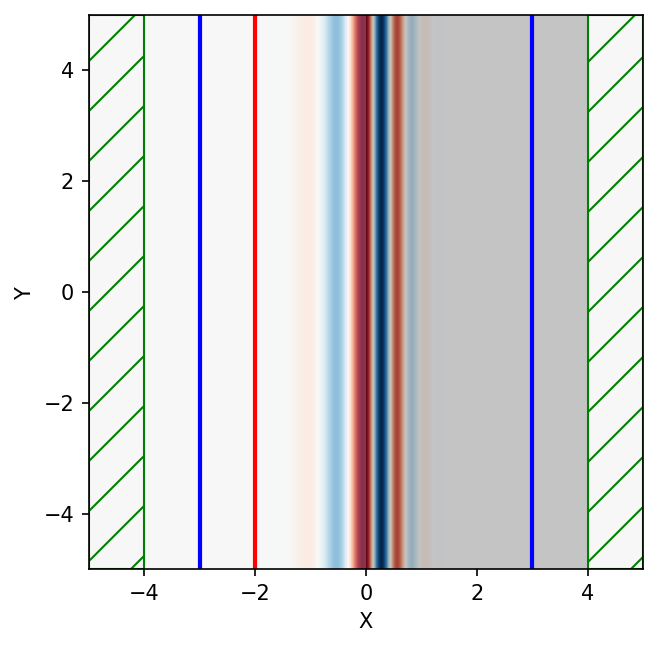

In [9]:
geometry = [mp.Block(
        mp.Vector3(4, 10, 0),
        center=mp.Vector3(2,0),
        material=SiO2
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiO2],
                    k_point=mp.Vector3(0,10,0))

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(4 - 0.5/resolution, 0, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(10,mp.Ez,pt,1e-3))
# sim.run(until=100)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

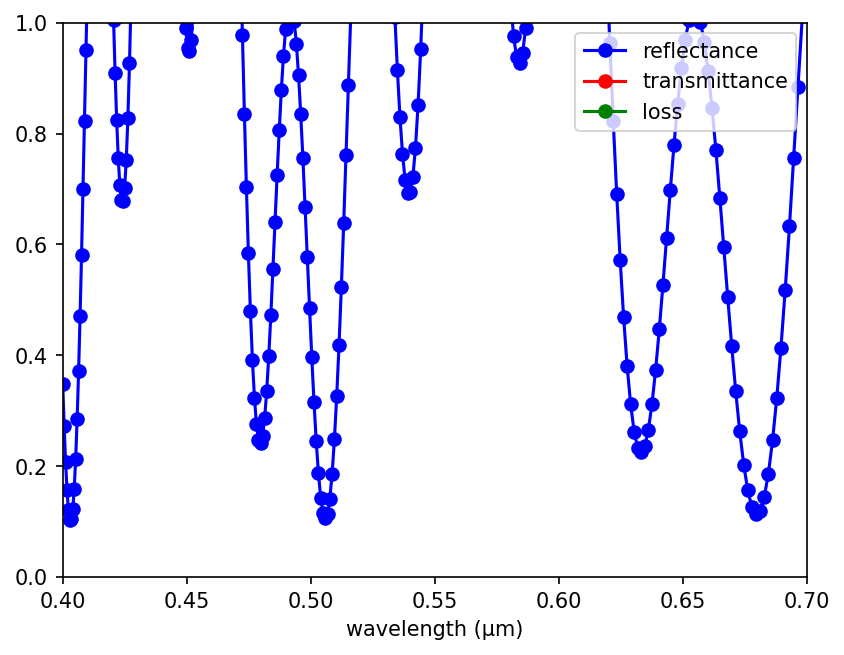

In [10]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

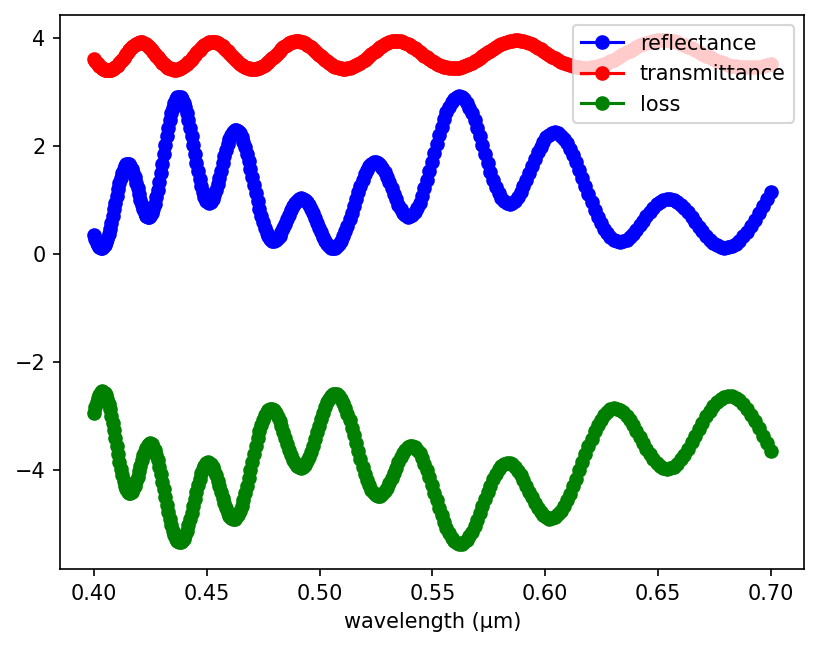

In [11]:
wl = [] #resolution20
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()